In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
import pandas as pd

In [5]:
training_path = './Data/train/'
validation_path = './Data/Validation/'
test_path = './Data/Test/'

def collect_files(directory_path):
    return glob(os.path.join(directory_path, '*', '*.jp*g'))

training_files = collect_files(training_path)

validation_files = collect_files(validation_path)

test_files = collect_files(test_path)

classes = [os.path.basename(class_dir) for class_dir in glob(os.path.join(training_path, '*'))]


118


In [3]:
IMAGE_SIZE = [100, 100]
num_epochs = 10
batch_size = 32
loss = 'sparse_categorical_crossentropy'
optimiser = 'adam'
metrics = ['accuracy']


In [ ]:
stop_images = [image for image in training_files if 'stop' in image.lower()]
uturn_images = [image for image in training_files if 'uturn' in image.lower()]

def display_images(images, num_columns=5):
    num_images = len(images)
    num_rows = (num_images - 1) // num_columns + 1

    plt.figure(figsize=(20, 20)) 

    for i, image_path in enumerate(images):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_images(stop_images) 
display_images(uturn_images)

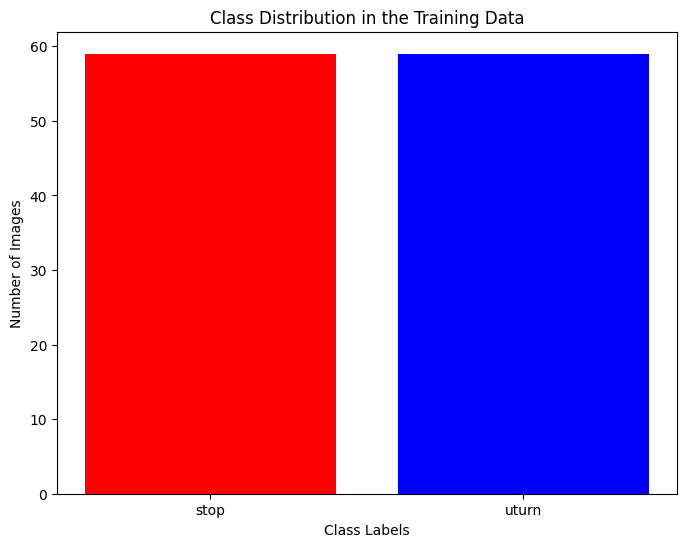

In [5]:
import matplotlib.pyplot as plt

class_labels = ["stop", "uturn"]
class_counts = [len(stop_images), len(uturn_images)]


plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color = ['red', 'blue'])
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Training Data')
plt.show()


In [6]:
X_train = training_path
y_valid = validation_path
test = test_path


In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet',
    include_top = False
    )

for each_layer in vgg.layers:
    each_layer.trainable = False

X = tf.keras.layers.Flatten()(vgg.output)
y_pred = tf.keras.layers.Dense(
    len(classes),
    activation = 'softmax'
    )(X)

model = tf.keras.models.Model(
    inputs = vgg.input,
    outputs = y_pred
    )

model.compile(
    loss = loss,
    optimizer = optimiser,
    metrics = metrics
    )


model.summary()

In [8]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range=[0.5,1.3],
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    )

training_generator = generator.flow_from_directory(
    directory = X_train,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'sparse'
    )

validation_generator = generator.flow_from_directory(
    directory = y_valid,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'sparse'
    )

test_generator = generator.flow_from_directory(
    directory = test,
    target_size = IMAGE_SIZE,
    shuffle = False,
    batch_size = batch_size * 2
    )

Found 118 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:

history = model.fit_generator(
    generator = training_generator,
    validation_data = validation_generator,
    epochs = num_epochs,
    steps_per_epoch = len(training_files) // batch_size,
    validation_steps = len(validation_files) // batch_size
    )

In [10]:
import pickle

model.save('CVE_model.pkl')

INFO:tensorflow:Assets written to: CVE_model.pkl\assets


INFO:tensorflow:Assets written to: CVE_model.pkl\assets


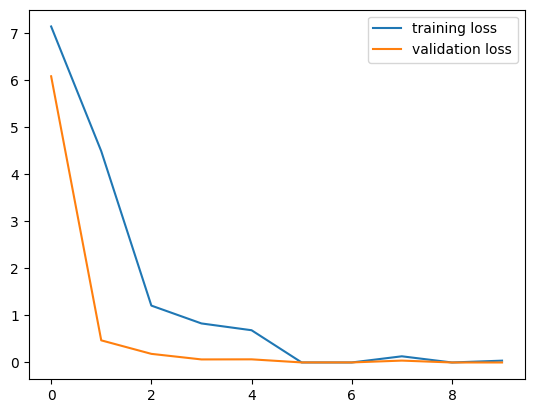

In [11]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

## 10.2. Train vs Validation Accuracy

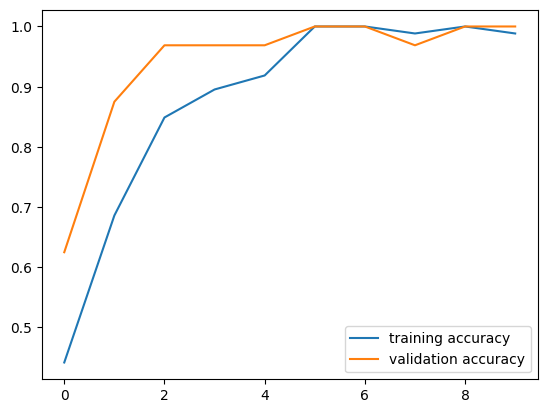

In [12]:
# Fill up this cell
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

In [13]:
from tensorflow.keras.models import load_model

model = load_model('CVE_model.pkl')

In [14]:
# Fill up this cell
y_pred = []
y_true = []

each_index = 0

for each_X, each_y in test_generator:
    each_index += 1

    each_y_pred = model.predict(each_X)
    each_y_pred = np.argmax(each_y_pred, axis = 1)
    each_y_true = np.argmax(each_y, axis = 1)
    y_pred = np.concatenate((y_pred, each_y_pred))
    y_true = np.concatenate((y_true, each_y_true))

    if len(y_true) >= len(test_files):
        break

2/2 [==============================] - 1s 98ms/step


In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
df_cm = pd.DataFrame(cm, index=['Stop', 'Uturn'], columns=['Stop', 'Uturn'])
df_cm.head()

,Stop,Uturn
Stop,19,1
Uturn,2,18
